In [44]:
import torch
import random
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import TwoSlopeNorm

In [45]:
def get_device():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"

device = get_device()
print(f"Using {device} device")

Using mps device


In [46]:
NUM_EPOCHS = 10
BATCHS_PER_EPOCH = 5000
BATCH_SIZE = 150
LEARNING_RATE = 1e-3
IMPORTANCE = (0.7 ** torch.arange(0, 20)).to(device)

In [47]:
class ToyModel(nn.Module):
    def __init__(self, m, n, include_ReLU):
        '''Create a toy model

        Args:
            m (int): the number of neurons (as described in original paper)
            n (int): the number of features the Toy model can map.
            (The weight matrix is delcared to be m * n)

            include_ReLU (bool): if True, a nonlinearity is added to the network
        '''
        super().__init__()
        self.weights = nn.Parameter(torch.randn(m, n), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(n, 1), requires_grad=True)
        self.ReLU = nn.ReLU(inplace=True)
        self.inclue_ReLU = include_ReLU
        
    def forward(self, x): # x is 5 * 1
        # print("w", self.weights)
        # print("x", x)
        hidden = self.weights @ x
        # print("hidden", hidden)
        final = self.weights.T @ hidden
        final += self.bias
        if self.inclue_ReLU:
            return self.ReLU(final)
        else:
            return final

class ImporanceWeightedMSE(nn.Module):
    def __init__(self):
        super(ImporanceWeightedMSE, self).__init__()

    def forward(self, predictions, targets, importance):
        # print(predictions)
        # print("*"*50)
        # print(targets)
        # print("*"*50)
        sub_total = ((predictions - targets)**2).sum(0).flatten() / 10
        # print(sub_total)
        # print("*"*50)
        # print(sum(sub_total * importance))
        return sum(sub_total * importance)

In [48]:
def train(model, epochs, total_batchs, batch_size, loss_fn, optimizer, importance, sparsity):
    probability = 1 - sparsity
    model.train()
    loss_total = 0
    for epoch in range(epochs):
        for i in range(total_batchs):
            sparsity_tensor = torch.bernoulli(torch.full((20,1), probability))
            x = torch.rand(batch_size, 20, 1)
            x = (x*sparsity_tensor).to(device)
            pred = model(x)
            loss = loss_fn(pred, x, importance)
            loss_total += loss.item()
    
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # if i % 100:
                # print(loss_total)
            # return

        print("EPHOCH:", epoch + 1, "--> loss:", loss_total / (total_batchs * batch_size))
        loss_total = 0

In [49]:
def graph_weights(weights):
    w = weights.clone().cpu().detach()
    to_graph = w.T @ w
    colors = [(.4, 0, 1), (1, 1, 1), (1, .4, 0)]  # Purple -> White -> Orange
    n_bins = 100 
    cm = LinearSegmentedColormap.from_list("", colors, N=n_bins)
    
    norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
    
    plt.imshow(to_graph, cmap=cm, norm=norm)
    ax = plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

In [50]:
# m = ToyModel(5, 20, False)

In [51]:
# graph_weights(m.weights)

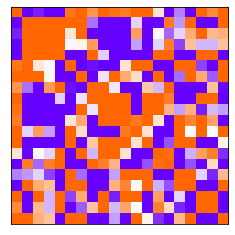

EPHOCH: 1 --> loss: 0.03554773780155182
EPHOCH: 2 --> loss: 0.010341690368970235
EPHOCH: 3 --> loss: 0.00939529257329305
EPHOCH: 4 --> loss: 0.008950521739482879
EPHOCH: 5 --> loss: 0.0075753332414627075
EPHOCH: 6 --> loss: 0.0062573670946757
EPHOCH: 7 --> loss: 0.005699758911689123
EPHOCH: 8 --> loss: 0.005324684401035309
EPHOCH: 9 --> loss: 0.005062678485631943
EPHOCH: 10 --> loss: 0.004897659701347351


In [52]:
# IMPORTANCE = torch.arange(1, 0, -0.2).to(device)
SPARSITY = 0.0

model_0_sparsity = ToyModel(5, 20, False).to(device)
graph_weights(model_0_sparsity.weights)
optimizer = torch.optim.SGD(model_0_sparsity.parameters(), lr=LEARNING_RATE)
loss_func = ImporanceWeightedMSE()

train(model_0_sparsity, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE, SPARSITY)

In [53]:
IMPORTANCE

tensor([1.0000, 0.7000, 0.4900, 0.3430, 0.2401, 0.1681, 0.1176, 0.0824, 0.0576,
        0.0404, 0.0282, 0.0198, 0.0138, 0.0097, 0.0068, 0.0047, 0.0033, 0.0023,
        0.0016, 0.0011], device='mps:0')

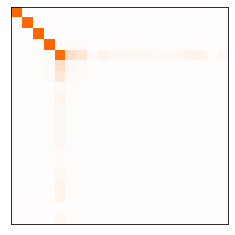

In [54]:
graph_weights(model_0_sparsity.weights)